In [1]:
%reload_kedro

2023-05-04 14:25:29,179 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/crypto_msc_thesis
2023-05-04 14:25:29,697 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-05-04 14:25:29,827 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-05-04 14:25:29,828 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array #useful to parse values

### XGBoost

In [4]:
model = catalog.load("xgboost_fitted_model")
X_test = catalog.load("xgboost_features_test")
y_test = catalog.load("xgboost_target_test")
y_pred = catalog.load("xgboost_model_predict")

df_model_rpt = catalog.load("xgboost_model_reporting")

2023-05-04 14:25:30,746 - kedro.io.data_catalog - INFO - Loading data from `xgboost_fitted_model` (PickleDataSet)...
2023-05-04 14:25:30,812 - kedro.io.data_catalog - INFO - Loading data from `xgboost_features_test` (ParquetDataSet)...
2023-05-04 14:25:30,872 - kedro.io.data_catalog - INFO - Loading data from `xgboost_target_test` (ParquetDataSet)...
2023-05-04 14:25:30,877 - kedro.io.data_catalog - INFO - Loading data from `xgboost_model_predict` (ParquetDataSet)...
2023-05-04 14:25:30,883 - kedro.io.data_catalog - INFO - Loading data from `xgboost_model_reporting` (ParquetDataSet)...


In [5]:
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=y_pred)
_roc_auc_score

0.5670522251945526

In [6]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.56      0.67      0.61       257
           1       0.58      0.46      0.52       256

    accuracy                           0.57       513
   macro avg       0.57      0.57      0.56       513
weighted avg       0.57      0.57      0.56       513



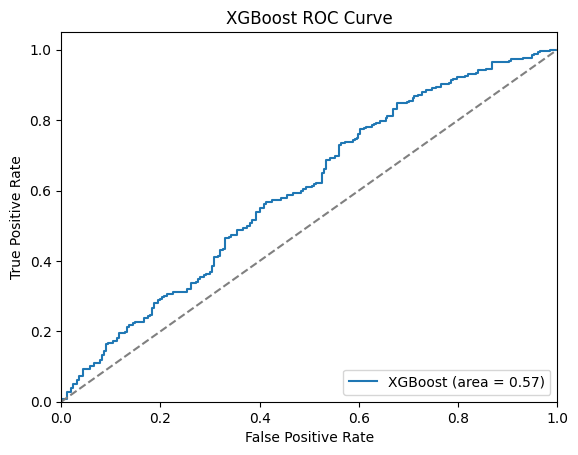

In [7]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.figure()

plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % _roc_auc_score)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")

plt.savefig("/Users/gpalazzo/Desktop/fig_xgboost_roc_curve.png")

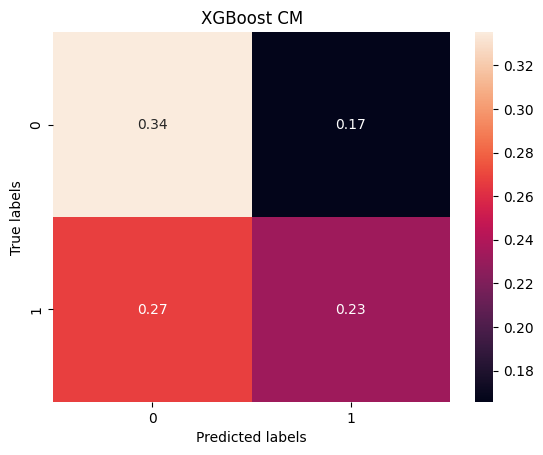

In [8]:
cm = eval(df_model_rpt["confusion_matrix"][0])

ax = plt.subplot()
plot = sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title("XGBoost CM")

fig = plot.get_figure()
fig.savefig("/Users/gpalazzo/Desktop/fig_xgboost_cm.png")

### LSTM

In [9]:
from crypto_thesis.data_domains.modeling.lstm import _build_lstm_timestamps_seq

In [10]:
y_test = catalog.load("lstm_target_test")
y_pred = catalog.load("lstm_model_predict")
X_test = catalog.load("lstm_features_test")

model = catalog.load("lstm_fitted_model")

seq_length = catalog.load("params:lstm_timestamp_seq_length")

df_model_rpt = catalog.load("lstm_model_reporting")

2023-05-04 14:25:31,797 - kedro.io.data_catalog - INFO - Loading data from `lstm_target_test` (ParquetDataSet)...
2023-05-04 14:25:31,802 - kedro.io.data_catalog - INFO - Loading data from `lstm_model_predict` (ParquetDataSet)...
2023-05-04 14:25:31,806 - kedro.io.data_catalog - INFO - Loading data from `lstm_features_test` (ParquetDataSet)...
2023-05-04 14:25:31,813 - kedro.io.data_catalog - INFO - Loading data from `lstm_fitted_model` (TensorFlowModelDataset)...
2023-05-04 14:25:33,861 - kedro.io.data_catalog - INFO - Loading data from `params:lstm_timestamp_seq_length` (MemoryDataSet)...
2023-05-04 14:25:33,862 - kedro.io.data_catalog - INFO - Loading data from `lstm_model_reporting` (ParquetDataSet)...


In [11]:
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=y_pred)
_roc_auc_score

0.56924094114786

In [12]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.57      0.55      0.56       257
           1       0.57      0.59      0.58       256

    accuracy                           0.57       513
   macro avg       0.57      0.57      0.57       513
weighted avg       0.57      0.57      0.57       513



In [13]:
X_test, _ = _build_lstm_timestamps_seq(X=X_test, y=y_test, seq_length=seq_length)
M_TEST = X_test.shape[0]

predict_probas = model.predict(x=X_test, batch_size=M_TEST, verbose=1)

1/1 [==============================] - 1s 590ms/step


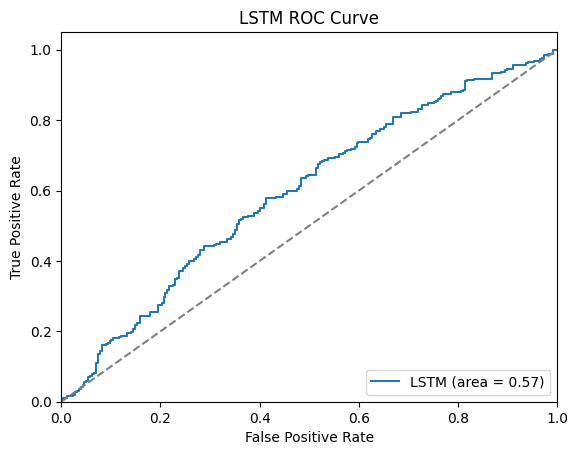

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, predict_probas.ravel())

plt.figure()
plt.plot(fpr, tpr, label='LSTM (area = %0.2f)' % _roc_auc_score)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('LSTM ROC Curve')
plt.legend(loc="lower right")

plt.savefig("/Users/gpalazzo/Desktop/fig_lstm_roc_curve.png")

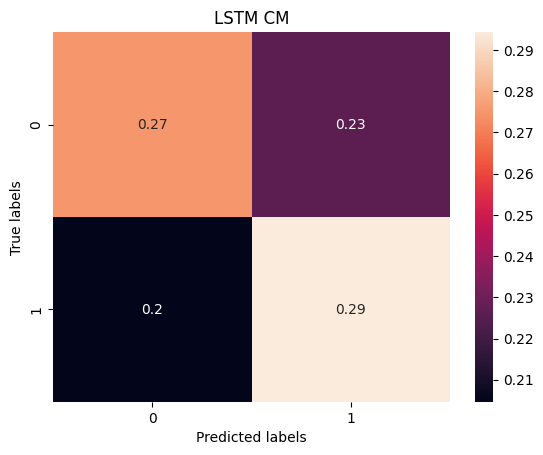

In [15]:
cm = eval(df_model_rpt["confusion_matrix"][0])

ax = plt.subplot()
plot = sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title("LSTM CM")

fig = plot.get_figure()
fig.savefig("/Users/gpalazzo/Desktop/fig_lstm_cm.png")

### LogReg

In [16]:
model = catalog.load("logreg_fitted_model")
X_test = catalog.load("logreg_features_test")
y_test = catalog.load("logreg_target_test")
y_pred = catalog.load("logreg_model_predict")

df_model_rpt = catalog.load("logreg_model_reporting")

2023-05-04 14:25:35,142 - kedro.io.data_catalog - INFO - Loading data from `logreg_fitted_model` (PickleDataSet)...
2023-05-04 14:25:35,146 - kedro.io.data_catalog - INFO - Loading data from `logreg_features_test` (ParquetDataSet)...
2023-05-04 14:25:35,153 - kedro.io.data_catalog - INFO - Loading data from `logreg_target_test` (ParquetDataSet)...
2023-05-04 14:25:35,157 - kedro.io.data_catalog - INFO - Loading data from `logreg_model_predict` (ParquetDataSet)...
2023-05-04 14:25:35,161 - kedro.io.data_catalog - INFO - Loading data from `logreg_model_reporting` (ParquetDataSet)...


In [17]:
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=y_pred)
_roc_auc_score

0.5019759241245136

In [18]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.50      0.99      0.67       257
           1       0.57      0.02      0.03       256

    accuracy                           0.50       513
   macro avg       0.54      0.50      0.35       513
weighted avg       0.54      0.50      0.35       513



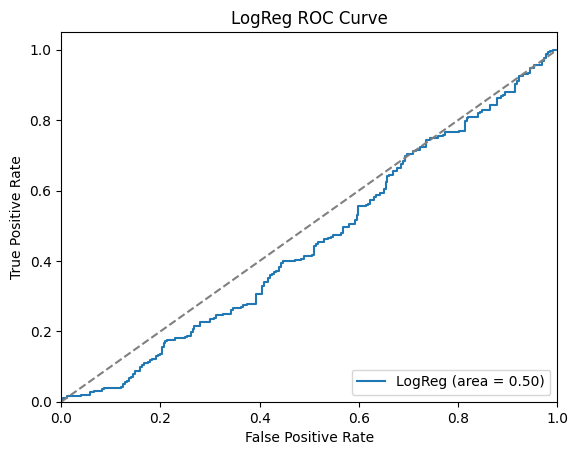

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='LogReg (area = %0.2f)' % _roc_auc_score)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('LogReg ROC Curve')
plt.legend(loc="lower right")

plt.savefig("/Users/gpalazzo/Desktop/fig_logreg_roc_curve.png")

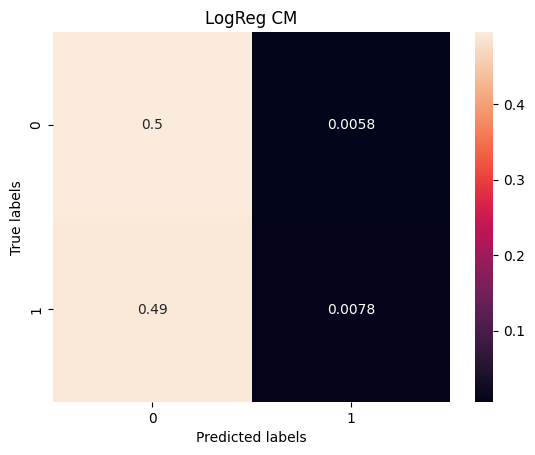

In [20]:
cm = eval(df_model_rpt["confusion_matrix"][0])

ax = plt.subplot()
plot = sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title("LogReg CM")

fig = plot.get_figure()
fig.savefig("/Users/gpalazzo/Desktop/fig_logreg_cm.png")